In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# https://pytorch.org/vision/0.11/auto_examples/plot_repurposing_annotations.html

# tracker = Tracker(metric, max_age=50, n_init=3)

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
    

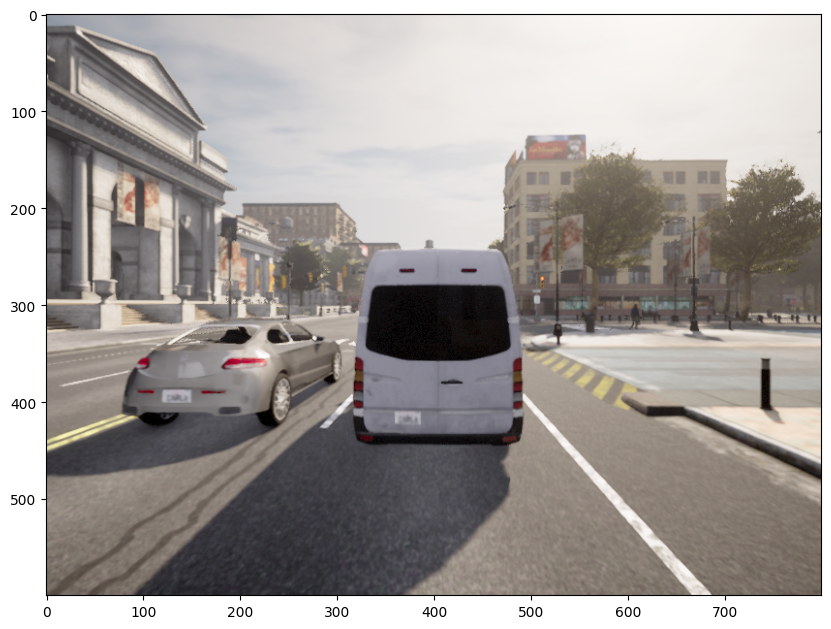

In [3]:
image = cv2.imread('/home/irfan/research/Thesis/HD_Map/HD_Map/rgb/00003854.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/irfan/research/Thesis/segment_anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/irfan/miniconda3/envs/net/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
predictor.set_image(image)

polarities:  [False False False ... False False False]


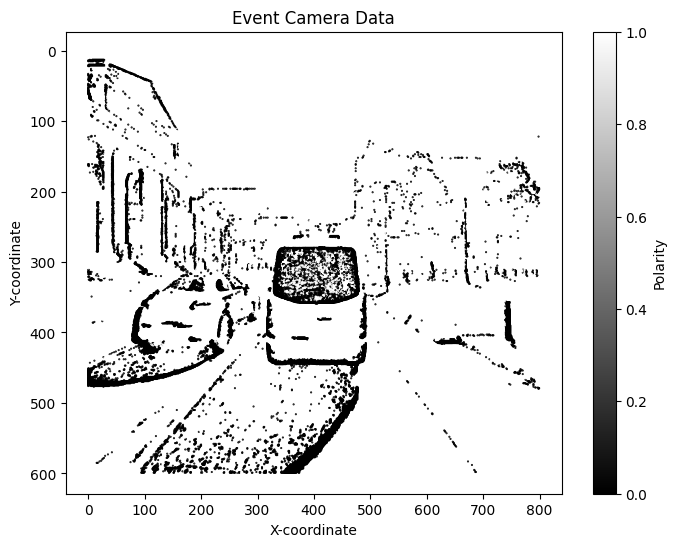

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data = np.load('/home/irfan/research/Thesis/HD_Map/HD_Map/dvs/00003854.npy', allow_pickle=True)

# Extract event data
timestamps = data.item()["t"]
x_coords = data.item()["x"]
y_coords = data.item()["y"]
polarities = data.item()["pol"]
print("polarities: ", polarities)
# Plot events
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=polarities, cmap='gray', marker='.', s=1)
plt.title('Event Camera Data')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.gca().invert_yaxis()  # Invert y-axis to match typical image coordinates
plt.colorbar(label='Polarity')
plt.show()

In [7]:
import numpy as np

def combine_arrays(x, y, polarity):
    # Ensure x, y, and polarity are numpy arrays
    x = np.array(x)
    y = np.array(y)
    polarity = np.array(polarity)
    
    # Combine x and y into a 2D array
    combined = np.vstack((x, y)).T
    
    # Filter the combined array where polarity is True and coordinates are not the same
    filtered_combined = combined[polarity]
    
    # Find unique rows and their counts
    unique_rows, counts = np.unique(filtered_combined, axis=0, return_counts=True)
    
    # Select rows that appear only once
    result = unique_rows[counts == 1]
    
    return result

# Example usage




result = combine_arrays(x_coords, y_coords, polarities)
print(len(result))

8786


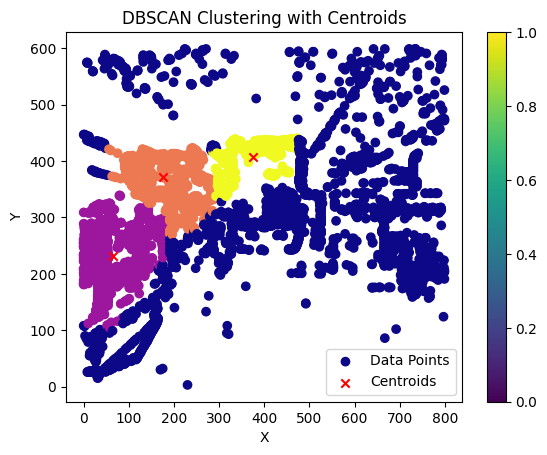

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Generate sample data
# points = input_point
points=result

# Choose eps based on the k-distance graph (elbow method)
eps = 40 # Adjust this value based on the graph

# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=300)
clusters = dbscan.fit_predict(points)

# Calculate centroids
unique_clusters = set(clusters)
centroids = []
for cluster in unique_clusters:
    if cluster != -1:  # Ignore noise points
        cluster_points = points[clusters == cluster]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)

centroids = np.array(centroids)

# Plotting the results
plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap='plasma', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering with Centroids')
plt.legend()
plt.colorbar()
plt.show()

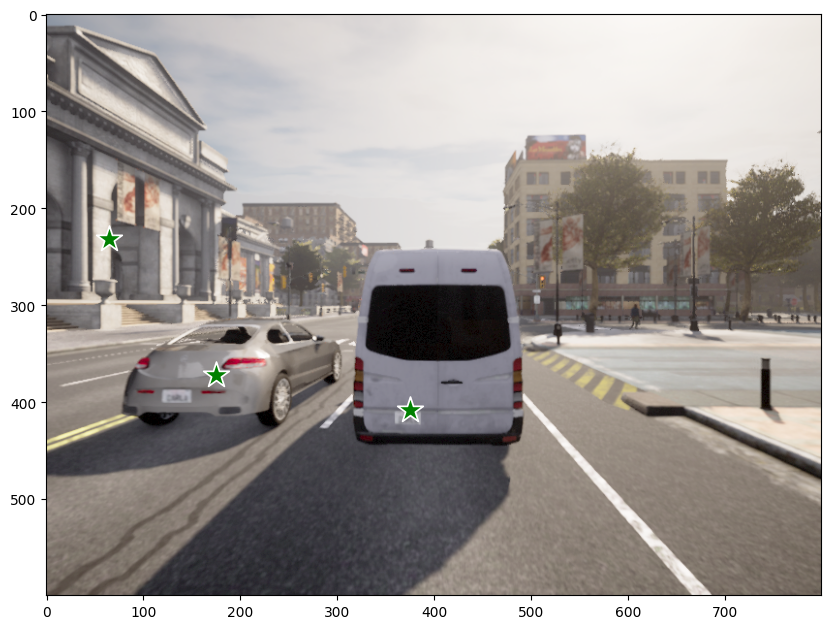

In [9]:
input_point=centroids
array=np.ones(centroids.shape[0])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(centroids,array, plt.gca())
plt.axis('on')
plt.show()  

In [12]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=array,
    multimask_output=True,
)

In [13]:
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [24]:
input=centroids[0].reshape(1,2)
# input_point=np.array([[375 , 408 ]])
input.shape

(1, 2)

In [33]:
#input_point=np.array([[375 , 408 ]])
input_point=centroids[0].reshape(1,2)
array=[1]
masks, scores, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


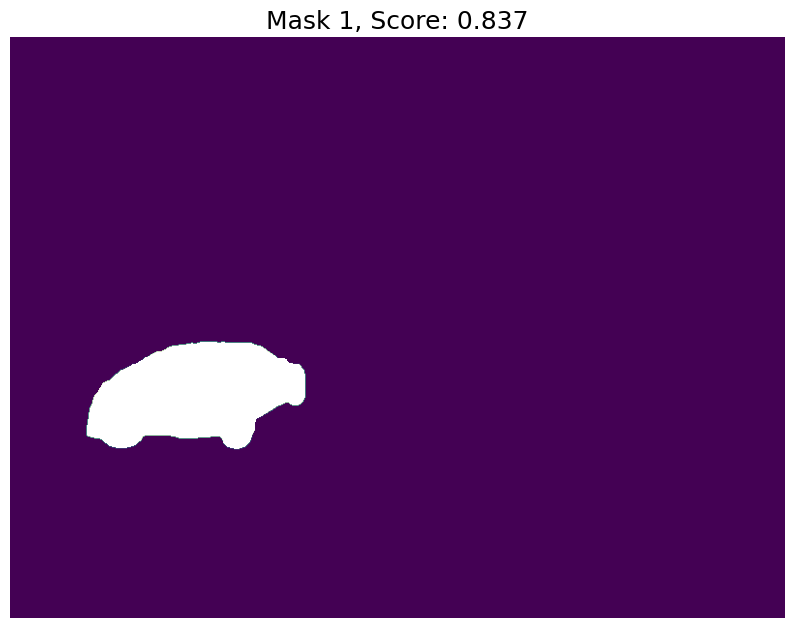

In [77]:
for i, (mask2, score) in enumerate(zip(largest_component_mask, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(mask2)
    show_mask(mask2, plt.gca())
    # show_points(input_point, array, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [74]:
from scipy.ndimage import label

# _, binary_mask = cv2.threshold(mask2, 127, 255, cv2.THRESH_BINARY)
binary_mask=masks2
labeled_mask, num_features = label(masks2)

# Find the size of each connected component
component_sizes = np.bincount(labeled_mask.ravel())

# Ignore the background (component 0)
component_sizes[0] = 0

# Get the label of the largest component
largest_component_label = component_sizes.argmax()

# Create a mask that only keeps the largest component
largest_component_mask = np.zeros_like(binary_mask, dtype=np.uint8)
largest_component_mask[labeled_mask == largest_component_label] = 255

In [76]:
largest_component_mask.shape

(1, 600, 800)

In [73]:
input_point=centroids[1].reshape(1,2)
masks2, scores2, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
input_point=centroids[2].reshape(1,2)
masks3, scores3, logits = predictor.predict(
    # point_coords=input_point,
    point_coords=input_point,
    point_labels=array,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

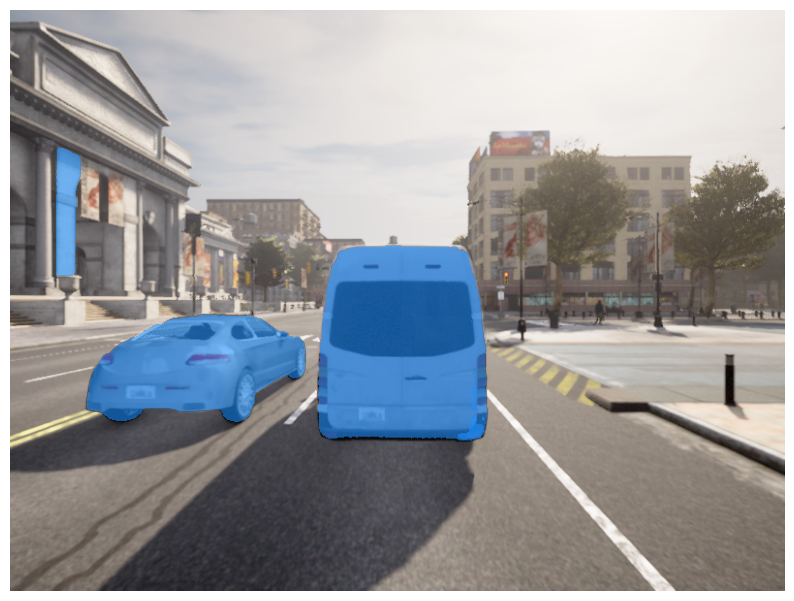

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_mask(masks2, plt.gca())
show_mask(masks3, plt.gca())
    # show_points(input_point, array, plt.gca())
    # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()  

/tmp/ipykernel_4341/1147568257.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_boxes = torch.tensor(boxes).float()


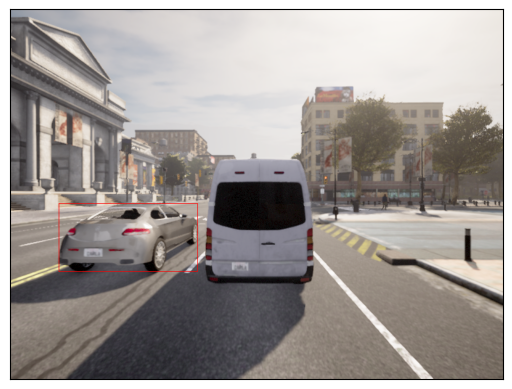

In [82]:
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import masks_to_boxes
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


ASSETS_DIRECTORY = "assets"

plt.rcParams["savefig.bbox"] = "tight"
masks_array=[masks,largest_component_mask,masks3]


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
int_array = np.where(largest_component_mask, 255, 0)
torch_tensor = torch.from_numpy(int_array)
boxes = masks_to_boxes(torch_tensor)
torch_boxes = torch.tensor(boxes).float()
torch_tensor = torch.from_numpy(image).permute(2, 0, 1)
drawn_boxes = draw_bounding_boxes(torch_tensor, torch_boxes, colors="red")
show(drawn_boxes)

In [37]:
centroid

array([375.2889115, 407.7792472])

/tmp/ipykernel_4341/3396737202.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_boxes = torch.tensor(boxes).float()


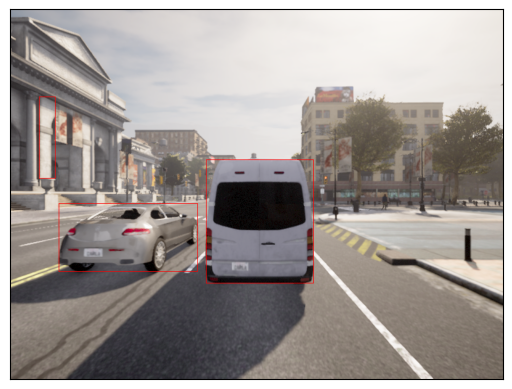

In [83]:

boxes_tensor=torch.tensor([])
for i in range(len(centroids)):
    int_array = np.where(masks_array[i], 255, 0)
    torch_tensor = torch.from_numpy(int_array)
    boxes = masks_to_boxes(torch_tensor)
    torch_boxes = torch.tensor(boxes).float()
    boxes_tensor = torch.cat((boxes_tensor, torch_boxes), dim=0)

torch_tensor = torch.from_numpy(image).permute(2, 0, 1)
drawn_boxes = draw_bounding_boxes(torch_tensor, boxes_tensor, colors="red")
show(drawn_boxes)